In [2]:
import os

In [3]:
all_images = ['./data/'+x for x in os.listdir('data/') if x.endswith('.jpg')]
all_labels = [x for x in os.listdir('data/') if x.endswith('.jpg')]

categories = sorted(set([x[:-7] for x in all_labels]))
category2images = {category : [] for category in categories}
for img in all_labels:
    category2images[img[:-7]].append(img)
categories
category2images

{'bagel': ['bagel000.jpg',
  'bagel001.jpg',
  'bagel002.jpg',
  'bagel003.jpg',
  'bagel004.jpg',
  'bagel005.jpg',
  'bagel006.jpg',
  'bagel007.jpg',
  'bagel008.jpg',
  'bagel009.jpg',
  'bagel010.jpg',
  'bagel011.jpg',
  'bagel012.jpg',
  'bagel013.jpg',
  'bagel014.jpg',
  'bagel015.jpg',
  'bagel016.jpg',
  'bagel017.jpg',
  'bagel018.jpg',
  'bagel019.jpg',
  'bagel020.jpg',
  'bagel021.jpg',
  'bagel022.jpg',
  'bagel023.jpg',
  'bagel024.jpg',
  'bagel025.jpg',
  'bagel026.jpg',
  'bagel027.jpg',
  'bagel028.jpg',
  'bagel029.jpg',
  'bagel030.jpg',
  'bagel031.jpg',
  'bagel032.jpg',
  'bagel033.jpg',
  'bagel034.jpg',
  'bagel035.jpg',
  'bagel036.jpg',
  'bagel037.jpg',
  'bagel038.jpg',
  'bagel039.jpg',
  'bagel040.jpg',
  'bagel041.jpg',
  'bagel042.jpg',
  'bagel043.jpg',
  'bagel044.jpg',
  'bagel045.jpg',
  'bagel046.jpg',
  'bagel047.jpg',
  'bagel048.jpg',
  'bagel049.jpg',
  'bagel050.jpg',
  'bagel051.jpg',
  'bagel052.jpg',
  'bagel053.jpg',
  'bagel054.jpg',
 

In [4]:
import requests
import torch
from PIL import Image
import matplotlib.pyplot as plt
from io import BytesIO
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [5]:
from diffusers import StableUnCLIPImg2ImgPipeline
from transformers import CLIPTextModelWithProjection, CLIPTokenizer

c:\Users\jnguy\miniforge3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



In [7]:
# ──────────────────────────────────────────────────────────────
# 1.  Load unCLIP – vision side only (projection_dim = 1024)   ─
# ──────────────────────────────────────────────────────────────
pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
    "sd2-community/stable-diffusion-2-1-unclip",
    torch_dtype=torch.float16,
    variant="fp16"
).to(device)

vision_encoder = pipe.image_encoder                       # keep as-is (1024-d)

Loading pipeline components...: 100%|██████████| 9/9 [00:00<00:00, 16.65it/s]
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fail. Please make sure to use an accelerator to run the pipeline in inference, due to the lack of support for`float16` operations on this device in PyTorch. Please, remove the `torch_dtype=torch.float16` argument, or use another device for inference.
Pipelines loaded with `dtype=torch.float16` cannot run with `cpu` device. It is not recommended to move them to `cpu` as running them will fai

In [8]:
# ──────────────────────────────────────────────────────────────
# 2.  Swap in an OpenCLIP ViT-H/14 text branch (also 1024-d)  ─
# ──────────────────────────────────────────────────────────────
openclip_repo = "laion/CLIP-ViT-H-14-laion2B-s32B-b79K"     # projection_dim = 1024 :contentReference[oaicite:0]{index=0}
tokenizer = CLIPTokenizer.from_pretrained(openclip_repo)
text_encoder = CLIPTextModelWithProjection.from_pretrained(
    openclip_repo,
    torch_dtype=torch.float16
).to(device)

# optional: stuff them into the pipe so `pipe.tokenizer` etc. work
pipe.tokenizer, pipe.text_encoder = tokenizer, text_encoder

In [9]:
# ──────────────────────────────────────────────────────────────
# 3. Helpers                                              
# ──────────────────────────────────────────────────────────────
def embed_images(paths, batch_size=8):
    """Return (N,1024) image embeddings"""
    out, fe, enc = [], pipe.feature_extractor, pipe.image_encoder
    for i in range(0, len(paths), batch_size):
        imgs = [Image.open(p).convert("RGB") for p in paths[i:i + batch_size]]
        px   = fe(imgs, return_tensors="pt").pixel_values.to(enc.device, enc.dtype)
        with torch.no_grad():
            v = enc(px)[0]                              # (B,1024)
        out.append(v)
    return torch.cat(out)  # (N,1024)

def embed_texts(prompts, batch_size=64):
    """Return (N,1024) text embeddings"""
    vecs = []
    for i in range(0, len(prompts), batch_size):
        toks = tokenizer(prompts[i:i + batch_size],
                         padding=True, truncation=True, max_length=77,
                         return_tensors="pt").to(text_encoder.device)
        with torch.no_grad():
            t = text_encoder(**toks).text_embeds        # (B,1024)
        vecs.append(t)
    return torch.cat(vecs)  # (N,1024)
    

In [10]:
# ──────────────────────────────────────────────────────────────
# 4.  Sanity check on image-text similarity                                 
# ──────────────────────────────────────────────────────────────
img_vec = embed_images(["./data/bagel000.jpg"])
txt_vec = embed_texts(["bagel"])
print("cosine(bagel image, \"bagel\") →",
      (torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(txt_vec, dim=-1).T).item())        
# expect ≳ 0.3




cosine(bagel image, "bagel") → 0.2176513671875


In [15]:
#img_vec = embed_images(all_images)
#txt_vec = embed_texts(list(categories))
#np.save('txt_embeddings.npy', txt_vec)
img_vec = np.load('image_embedding.npy')
txt_vec = np.load('txt_embeddings.npy')

img_vec = torch.from_numpy(img_vec)
txt_vec = torch.from_numpy(txt_vec)

In [16]:
truelabels = []
for key in category2images.keys():
    for _ in range(len(category2images[key])):
        truelabels.append(key)
truelabels

['bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',
 'bagel',


In [17]:
#np.save('image_embedding.npy', img_vec)
#np.save('txt_embeddings', txt_vec)

sims = torch.nn.functional.normalize(img_vec, dim=-1) @ torch.nn.functional.normalize(txt_vec, dim=-1).T 

pred_idx = sims.argmax(dim=1)
pred_labels = [list(categories)[i] for i in pred_idx]

for img, pred, score in zip(all_images, pred_labels, sims.max(dim=1).values):
    print(f"{img} → {pred}   (score={score:.3f})")


./data/bagel000.jpg → bagel   (score=0.218)
./data/bagel001.jpg → bagel   (score=0.312)
./data/bagel002.jpg → bagel   (score=0.305)
./data/bagel003.jpg → bagel   (score=0.298)
./data/bagel004.jpg → bagel   (score=0.311)
./data/bagel005.jpg → bagel   (score=0.291)
./data/bagel006.jpg → bagel   (score=0.283)
./data/bagel007.jpg → bagel   (score=0.230)
./data/bagel008.jpg → bagel   (score=0.262)
./data/bagel009.jpg → bagel   (score=0.251)
./data/bagel010.jpg → bagel   (score=0.261)
./data/bagel011.jpg → bagel   (score=0.318)
./data/bagel012.jpg → bagel   (score=0.316)
./data/bagel013.jpg → bagel   (score=0.290)
./data/bagel014.jpg → bagel   (score=0.305)
./data/bagel015.jpg → bagel   (score=0.295)
./data/bagel016.jpg → bagel   (score=0.290)
./data/bagel017.jpg → bagel   (score=0.302)
./data/bagel018.jpg → bagel   (score=0.333)
./data/bagel019.jpg → bagel   (score=0.336)
./data/bagel020.jpg → bagel   (score=0.331)
./data/bagel021.jpg → bagel   (score=0.299)
./data/bagel022.jpg → bagel   (s

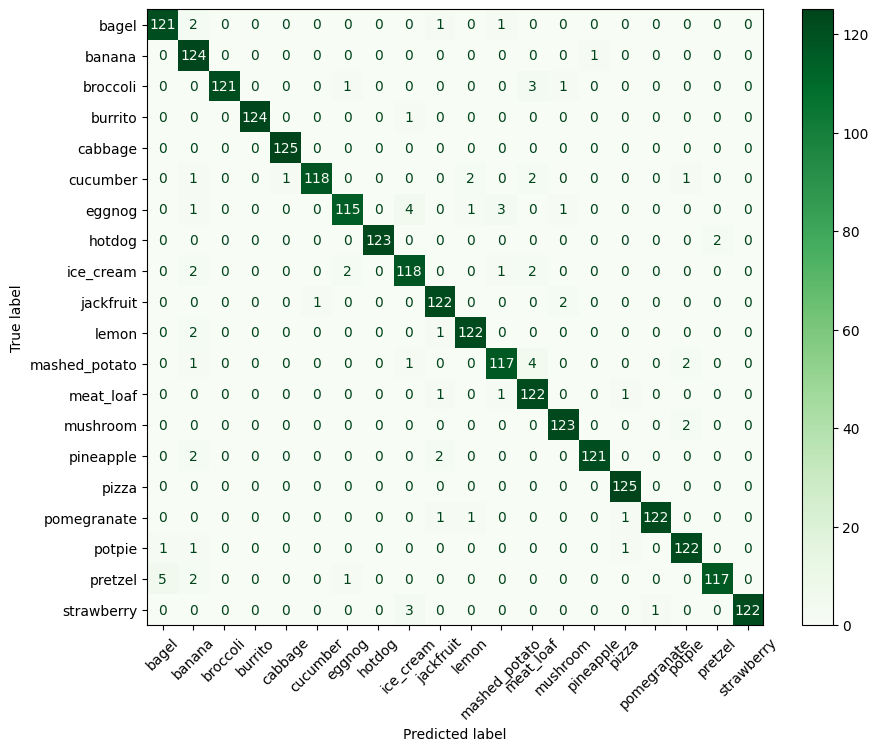

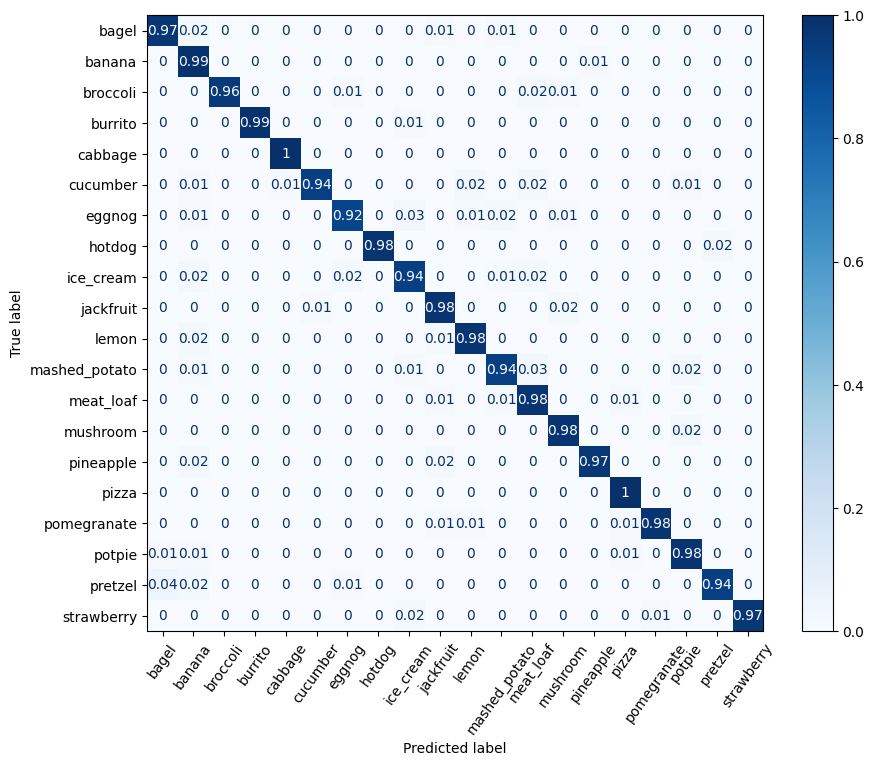

In [32]:
cm = confusion_matrix(truelabels, pred_labels, labels = categories)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
disp.plot(cmap='Greens', xticks_rotation=45)
plt.gcf().set_size_inches(10,8)

# Clip Accuracy
correct = 0
for pred, true in zip(pred_labels, truelabels):
    if pred == true:
        correct += 1
accuracy = correct / len(truelabels)

accuracy

cm2 = confusion_matrix(truelabels, pred_labels, labels = categories, normalize = 'true')
cm2 = np.round(cm2, 2)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=categories)
disp2.plot(cmap='Blues', xticks_rotation=54)
plt.gcf().set_size_inches(10,8)


Down Below is the Starter Code Tests


In [ ]:
# ──────────────────────────────────────────────────────────────
# 5.  Sanity check on image-image similarity                                 
# ──────────────────────────────────────────────────────────────
img_vec1 = embed_images(["./data/bagel001.jpg",
                       "./data/strawberry001.jpg",
                       "./data/burrito001.jpg", './data/pretzel001.jpg'])
img_vec2 = embed_images(["./data/bagel002.jpg",
                       "./data/strawberry002.jpg",
                       "./data/burrito002.jpg","./data/pretzel002.jpg" ])

sims = torch.nn.functional.normalize(img_vec1, dim=-1) @ torch.nn.functional.normalize(img_vec2, dim=-1).T 
sims = sims.detach().cpu().numpy()

In [ ]:
fig, ax = plt.subplots()

# Display the data as an image (heatmap)
im = ax.imshow(sims, cmap='viridis')

# Loop over the data and place text annotations
for i in range(sims.shape[0]):
    for j in range(sims.shape[1]):
        ax.text(j, i, sims[i, j], ha='center', va='center', color='black')

# Add a colorbar for reference
plt.colorbar(im)
plt.yticks([0, 1, 2,3], ['bagel1', 'strawberry1', 'burrito1', ' pretzel1'])
plt.xticks([0, 1, 2, 3], ['bagel2', 'strawberry2', 'burrito2', 'pretzel2'])

# Set title and display the plot
ax.set_title('Pairwise similarities between 6 different images')
plt.show()